# Projet IA HumanForYou


##  1. Préparation des données

### A. Initialisation du projet

In [19]:
# imports
import numpy as np
import seaborn as sns
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### B. Importation

In [20]:
import os
import pandas as pd

dataSets_Path = os.path.join(".\datasets")

generalData = pd.read_csv(os.path.join(dataSets_Path, "general_data.csv"))
employeeData = pd.read_csv(os.path.join(dataSets_Path, "employee_survey_data.csv"))
managerData = pd.read_csv(os.path.join(dataSets_Path, "manager_survey_data.csv"))
csvInTimeData = pd.read_csv(os.path.join(dataSets_Path, "in_time.csv"))
csvOutTimeData = pd.read_csv(os.path.join(dataSets_Path, "out_time.csv"))

intTimeData = csvInTimeData.rename(columns={'Unnamed: 0': 'EmployeeID'})
outTimeData = csvOutTimeData.rename(columns={'Unnamed: 0': 'EmployeeID'})

In [21]:
allData = pd.merge(employeeData, generalData, how='inner', on=['EmployeeID'])
allData = allData.merge(managerData, how='inner', on=['EmployeeID'])

""" allData = allData.merge(intTimeData, how='inner', on=['EmployeeID'])
allData = allData.merge(outTimeData, how='inner', on=['EmployeeID']) """

allData.drop("EmployeeID", axis=1, inplace=True)
allData.drop("Over18", axis=1, inplace=True) 
allData.drop("EmployeeCount", axis=1, inplace=True) 
allData.drop("StandardHours", axis=1, inplace=True) 

Test = allData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EnvironmentSatisfaction  4385 non-null   float64
 1   JobSatisfaction          4390 non-null   float64
 2   WorkLifeBalance          4372 non-null   float64
 3   Age                      4410 non-null   int64  
 4   Attrition                4410 non-null   object 
 5   BusinessTravel           4410 non-null   object 
 6   Department               4410 non-null   object 
 7   DistanceFromHome         4410 non-null   int64  
 8   Education                4410 non-null   int64  
 9   EducationField           4410 non-null   object 
 10  Gender                   4410 non-null   object 
 11  JobLevel                 4410 non-null   int64  
 12  JobRole                  4410 non-null   object 
 13  MaritalStatus            4410 non-null   object 
 14  MonthlyIncome           

### C. Decode valeur

In [22]:
allData['PerformanceRating'] = allData['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
allData['EnvironmentSatisfaction'] = allData['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['JobSatisfaction'] = allData['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['JobInvolvement'] = allData['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['WorkLifeBalance'] = allData['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})
allData['Education'] = allData['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'})
allData['JobLevel'] = allData["JobLevel"].replace({ 1 : 'Apprentice', 2: 'Junior Employee',3: 'Employee',4: 'Manager',5 : 'Director'})
allData['StockOptionLevel'] = allData['StockOptionLevel'].replace({ 0 : 'Low', 1: 'Medium', 2: 'High', 3: 'Very Hight'})

In [23]:
allData.describe(include="all")

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,...,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
count,4385,4390,4372,4410.000000,4410,4410,4410,4410.000000,4410,4410,...,4391.000000,4410.000000,4410,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410,4410
unique,4,4,4,NaN,2,3,3,NaN,5,6,...,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,4,2
top,High,Very High,Better,NaN,No,Travel_Rarely,Research & Development,NaN,Bachelor,Life Sciences,...,NaN,NaN,Low,NaN,NaN,NaN,NaN,NaN,High,Excellent
freq,1350,1367,2660,NaN,3699,3129,2883,NaN,1716,1818,...,NaN,NaN,1893,NaN,NaN,NaN,NaN,NaN,2604,3732
mean,NaN,NaN,NaN,36.923810,NaN,NaN,NaN,9.192517,NaN,NaN,...,2.694830,15.209524,NaN,11.279936,2.799320,7.008163,2.187755,4.123129,NaN,NaN
std,NaN,NaN,NaN,9.133301,NaN,NaN,NaN,8.105026,NaN,NaN,...,2.498887,3.659108,NaN,7.782222,1.288978,6.125135,3.221699,3.567327,NaN,NaN
min,NaN,NaN,NaN,18.000000,NaN,NaN,NaN,1.000000,NaN,NaN,...,0.000000,11.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,30.000000,NaN,NaN,NaN,2.000000,NaN,NaN,...,1.000000,12.000000,NaN,6.000000,2.000000,3.000000,0.000000,2.000000,NaN,NaN
50%,NaN,NaN,NaN,36.000000,NaN,NaN,NaN,7.000000,NaN,NaN,...,2.000000,14.000000,NaN,10.000000,3.000000,5.000000,1.000000,3.000000,NaN,NaN
75%,NaN,NaN,NaN,43.000000,NaN,NaN,NaN,14.000000,NaN,NaN,...,4.000000,18.000000,NaN,15.000000,3.000000,9.000000,3.000000,7.000000,NaN,NaN


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>,
        <AxesSubplot:title={'center':'MonthlyIncome'}>],
       [<AxesSubplot:title={'center':'NumCompaniesWorked'}>,
        <AxesSubplot:title={'center':'PercentSalaryHike'}>,
        <AxesSubplot:title={'center':'TotalWorkingYears'}>],
       [<AxesSubplot:title={'center':'TrainingTimesLastYear'}>,
        <AxesSubplot:title={'center':'YearsAtCompany'}>,
        <AxesSubplot:title={'center':'YearsSinceLastPromotion'}>],
       [<AxesSubplot:title={'center':'YearsWithCurrManager'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

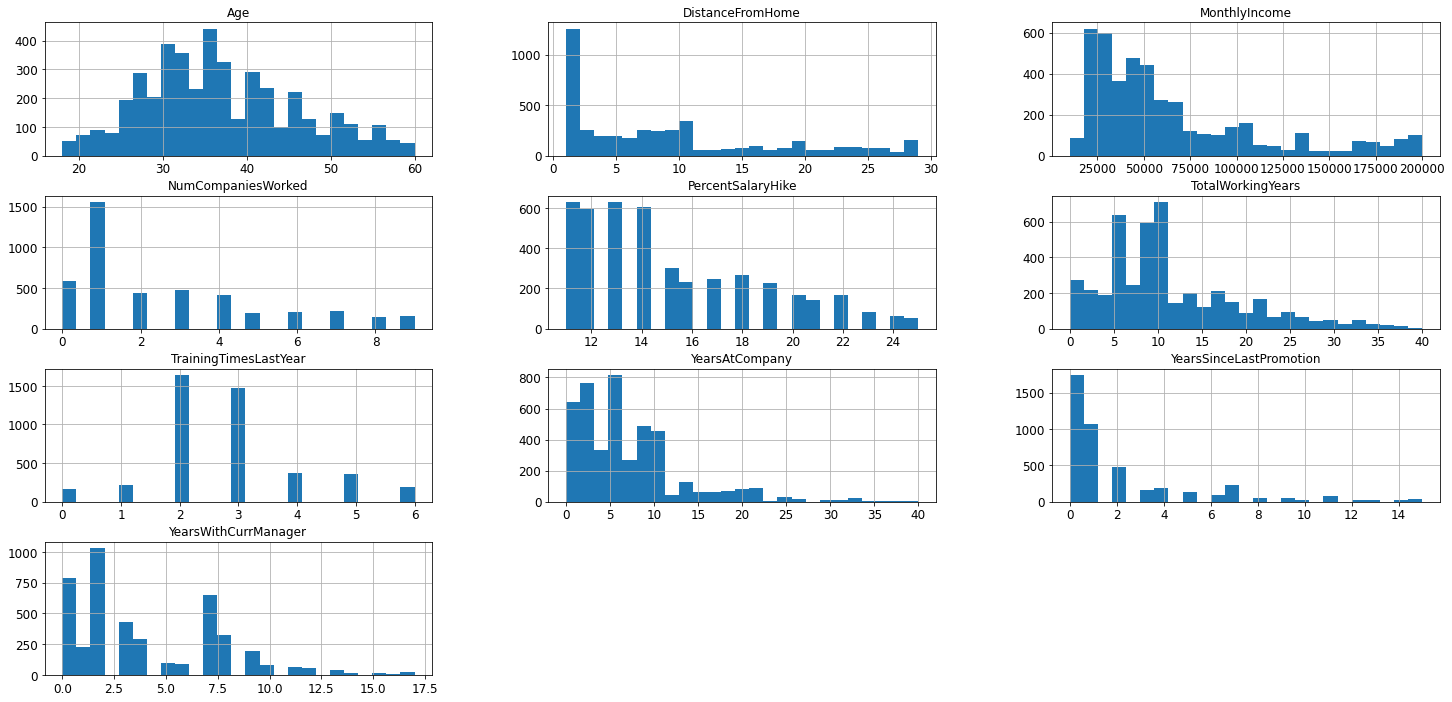

In [24]:
allData.hist(figsize=(25,12), bins=25,column=list(allData.columns))

##  2. Pré-traitement des données


### A. Analyse des variables



#### Analyse de toutes les variables qualitatives

Vous trouverez en dessous tous les graphes avec les variables de type `object` du jeu de données.

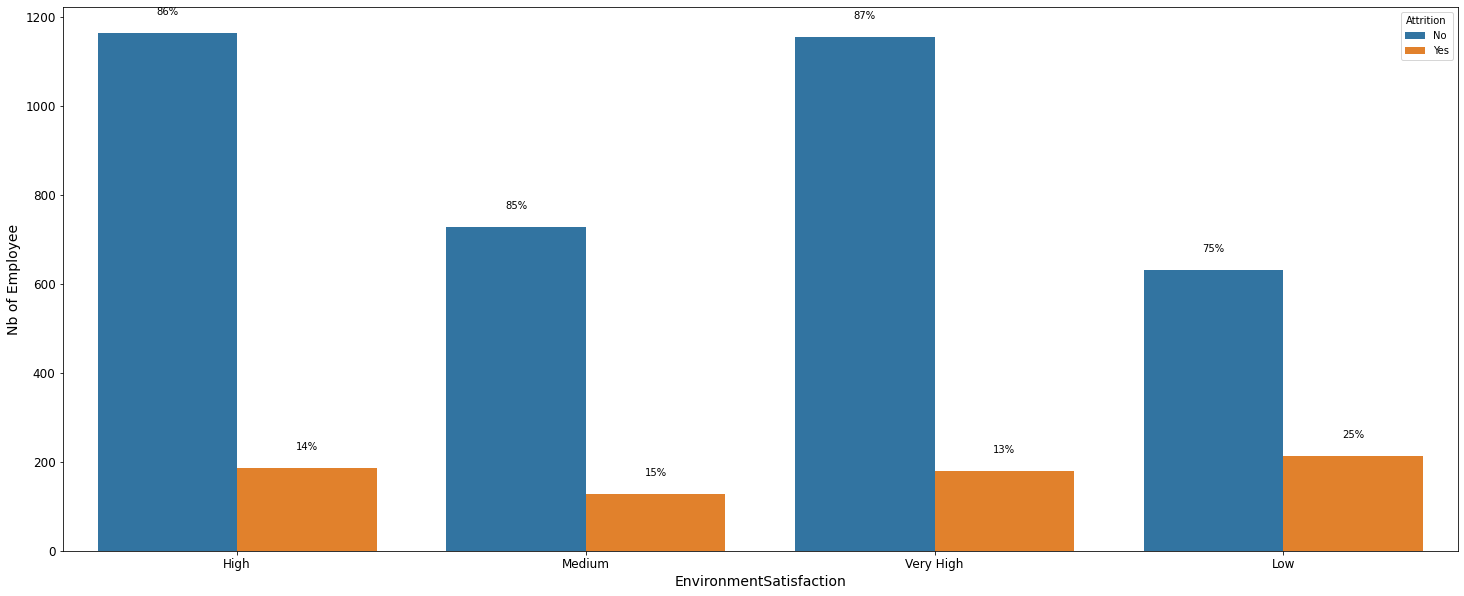

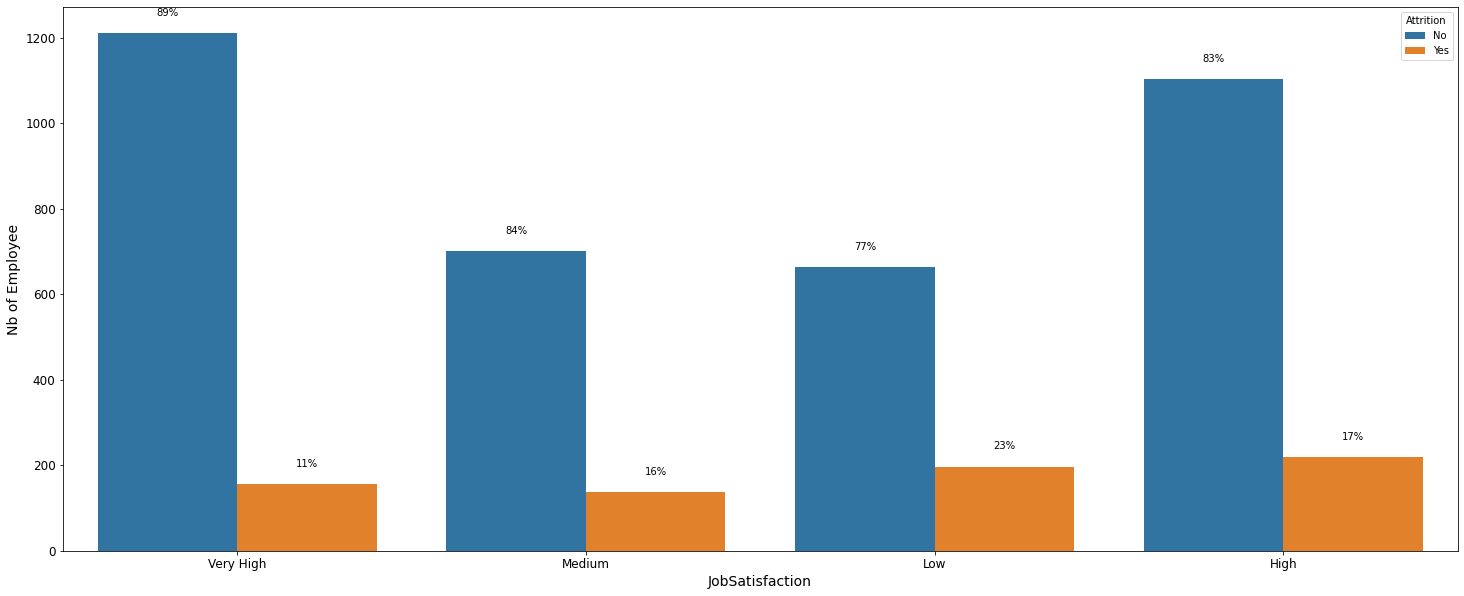

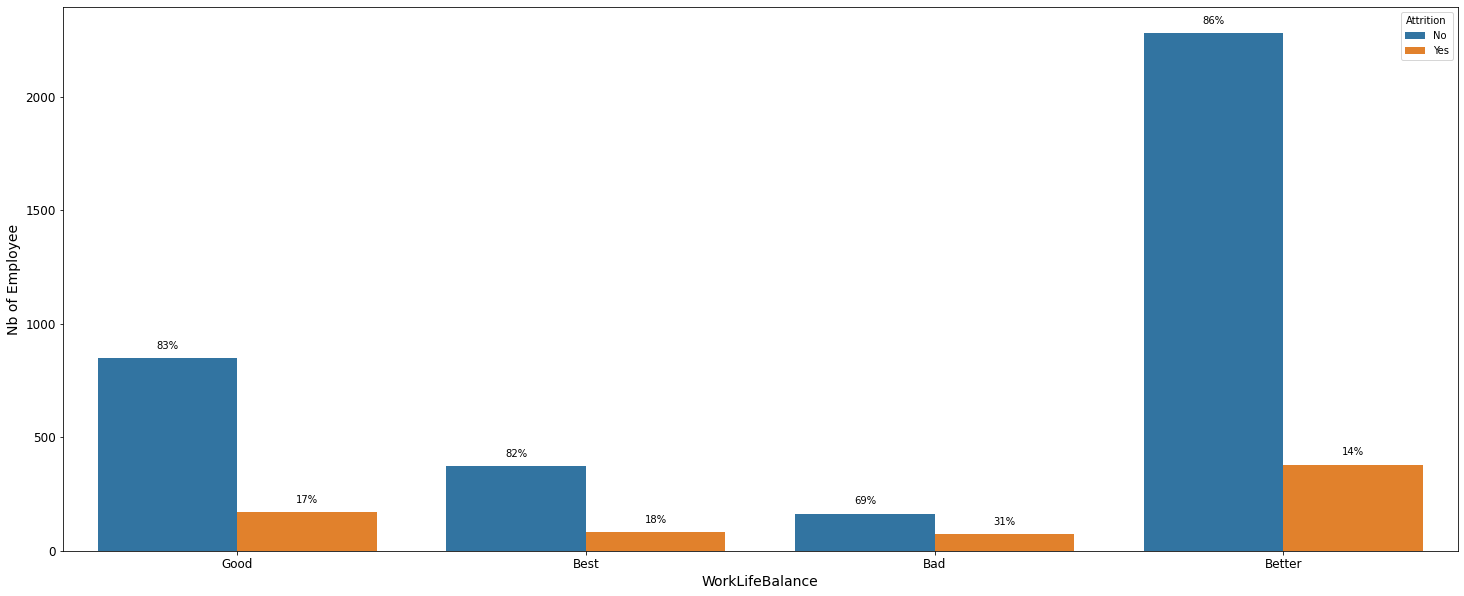

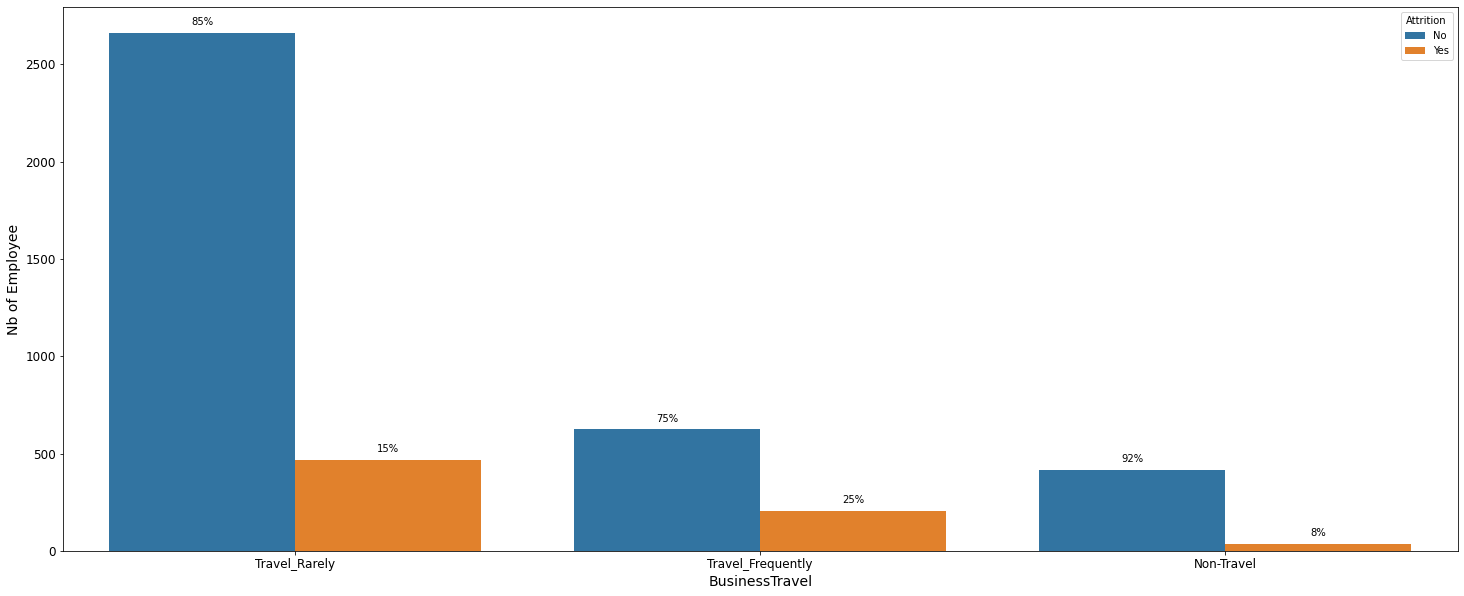

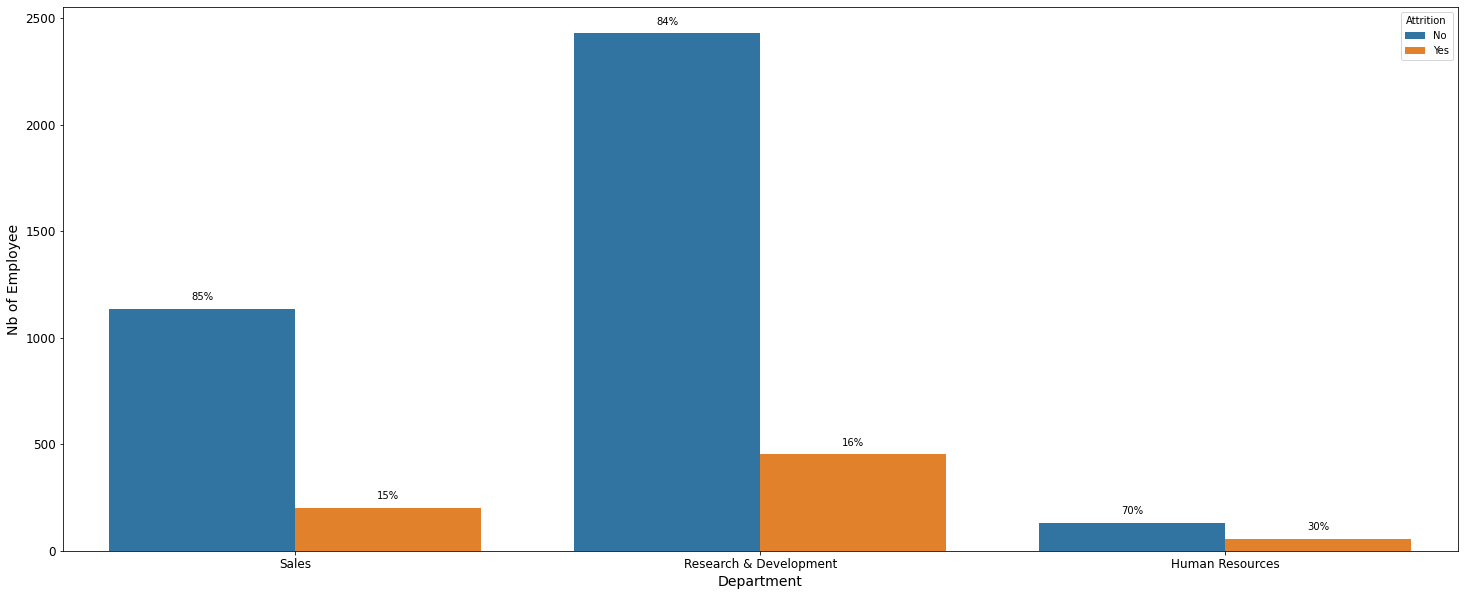

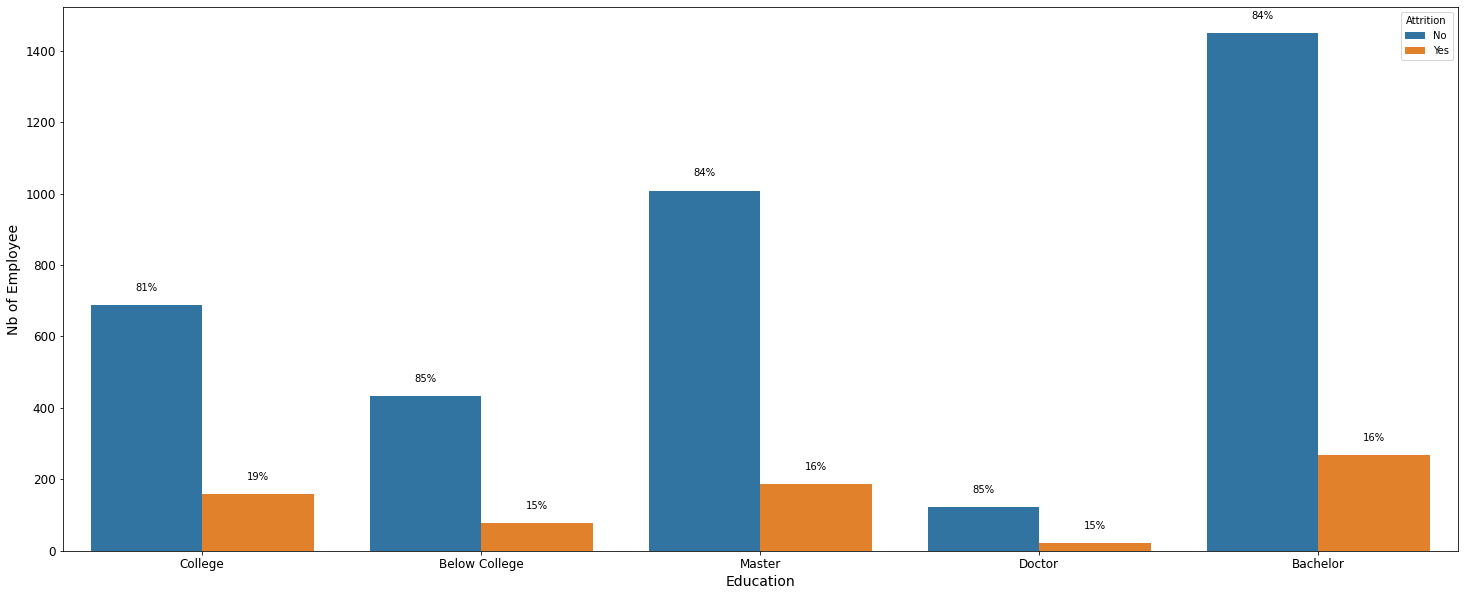

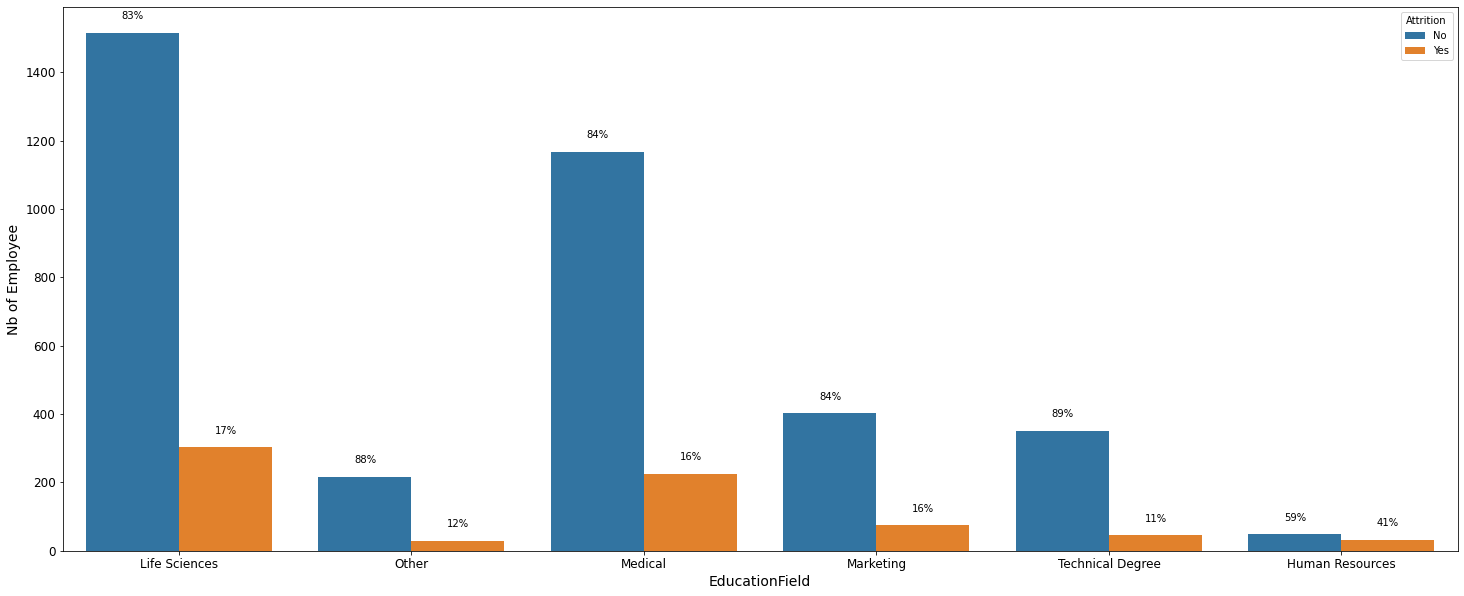

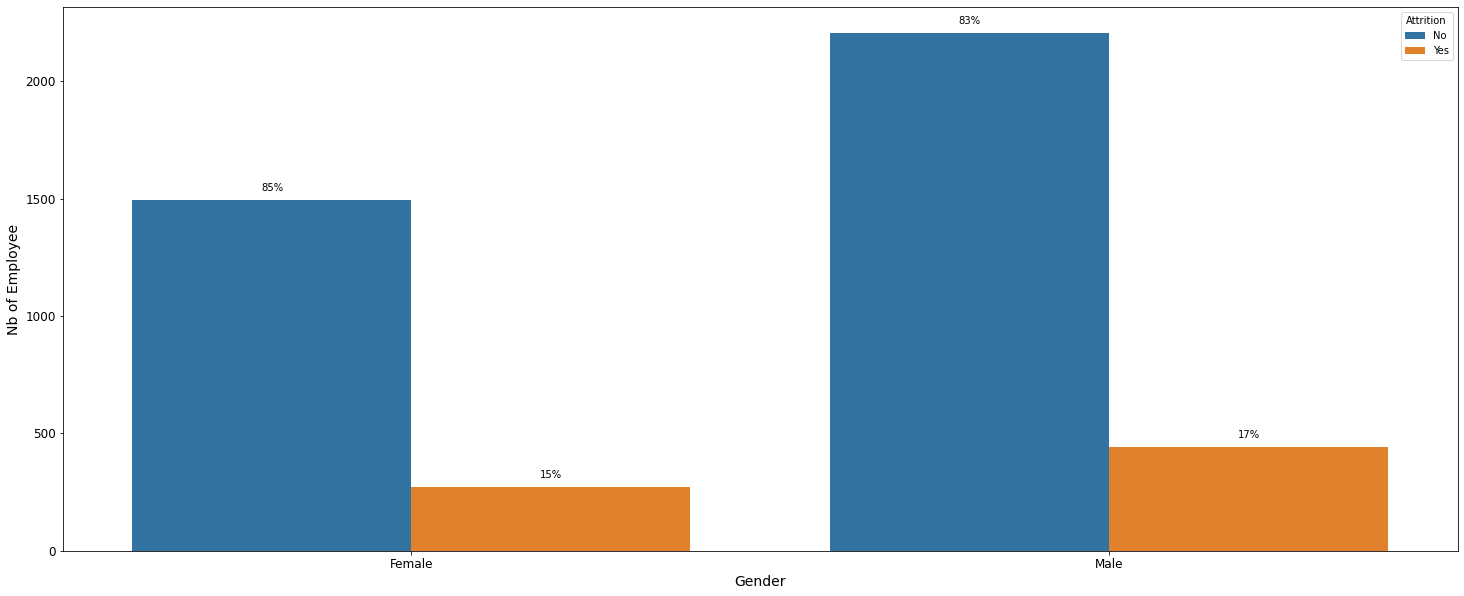

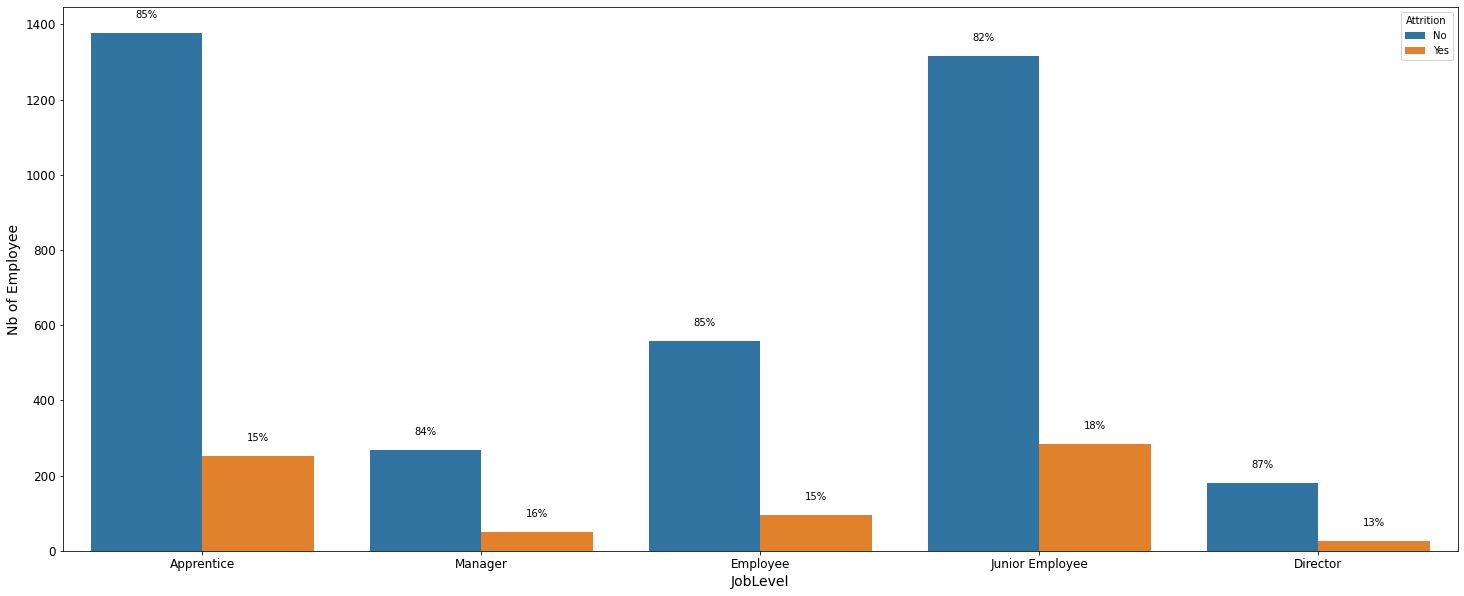

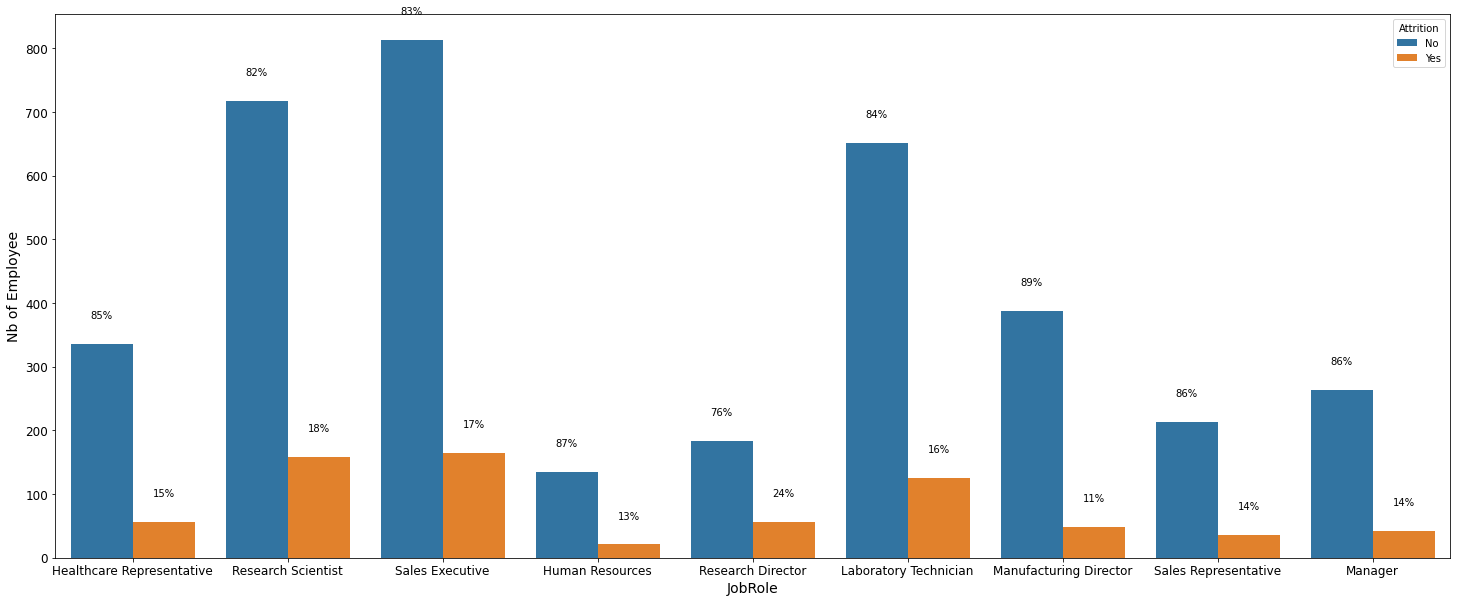

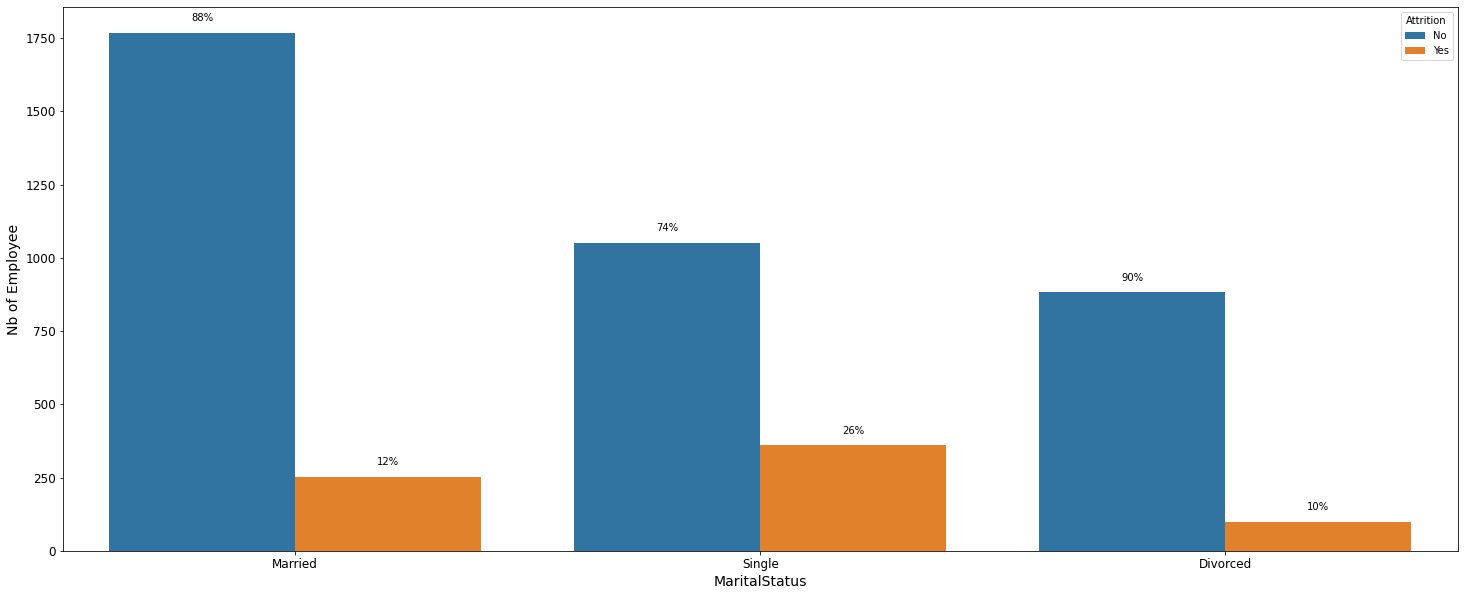

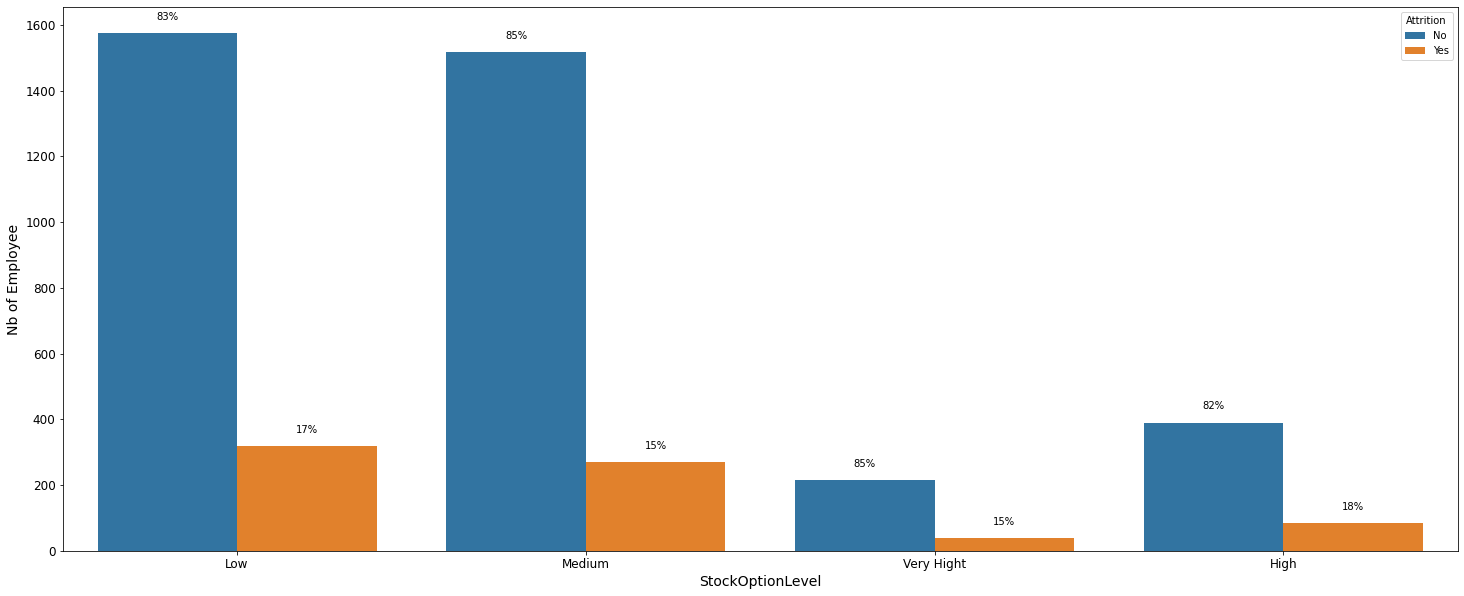

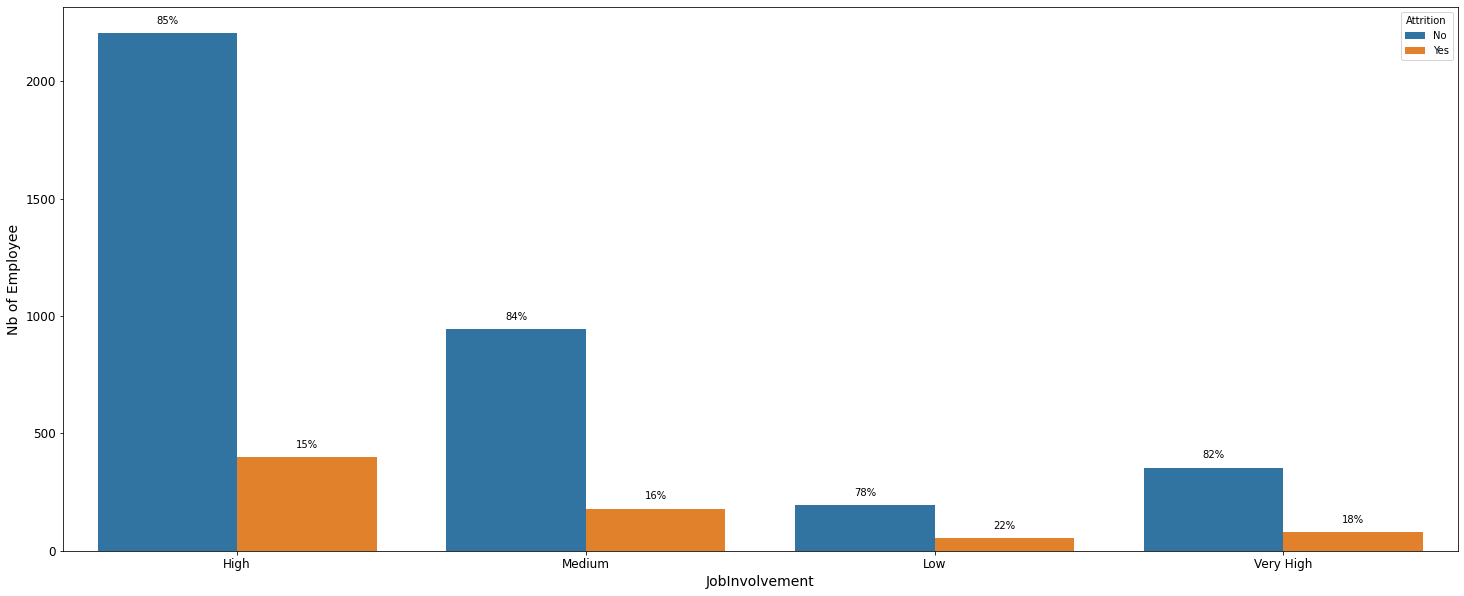

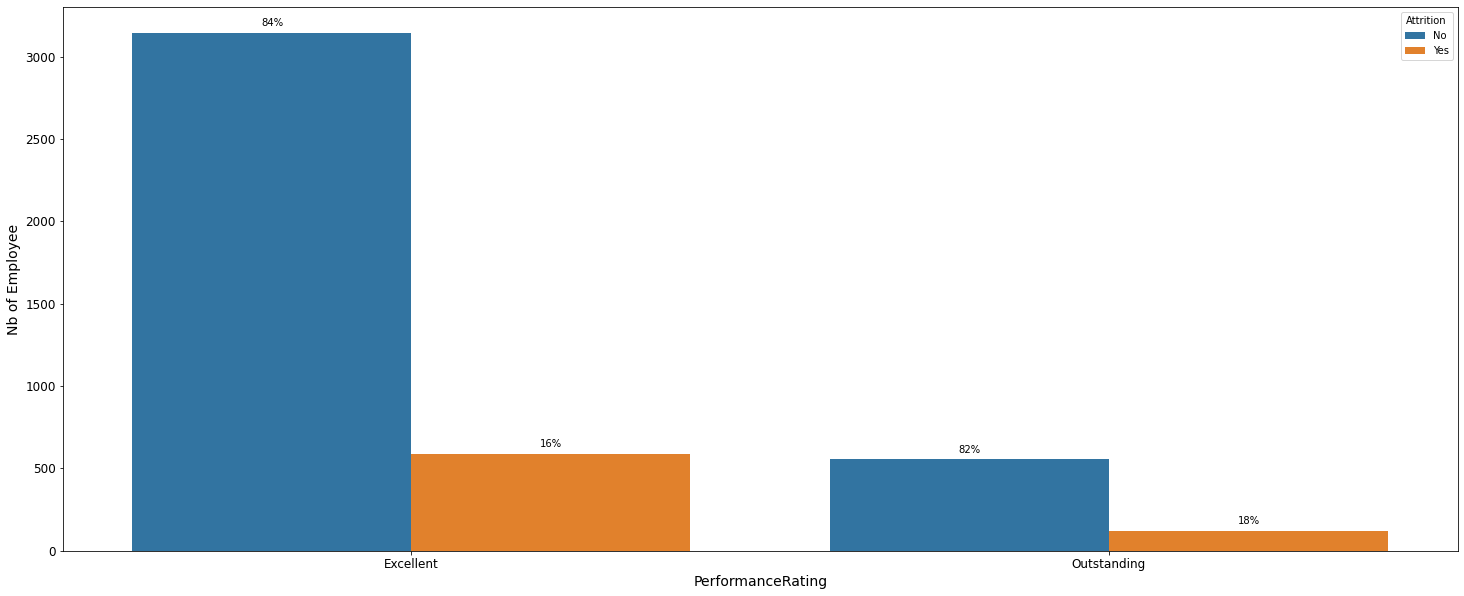

In [25]:
for name_column in allData.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        plt.figure(figsize=(25,10))
        ax = sns.countplot(x=name_column, data=allData, hue="Attrition")
        ax.set_ylabel('Nb of Employee')
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

#### Analyse de toutes les variables quantitatives

Vous trouverez en dessous tous les graphes avec les variables de type `number` du jeu de données.

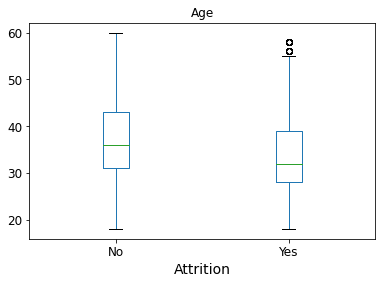

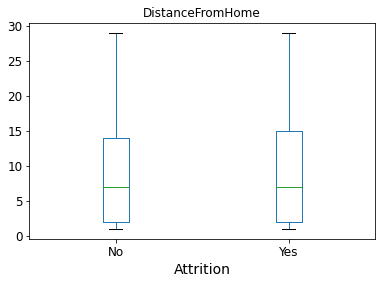

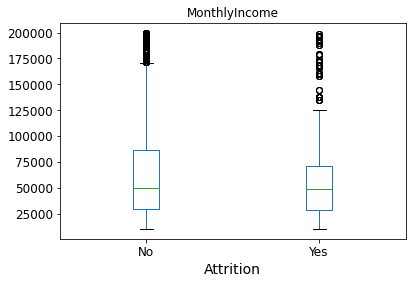

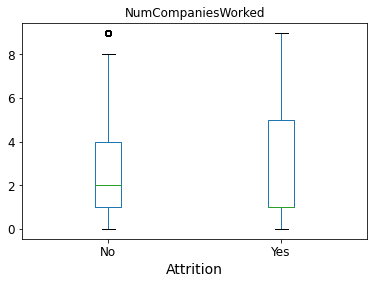

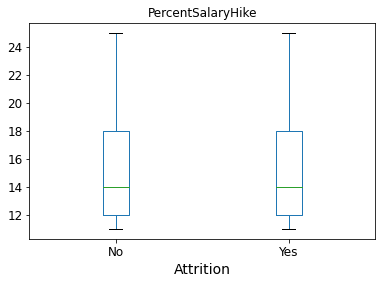

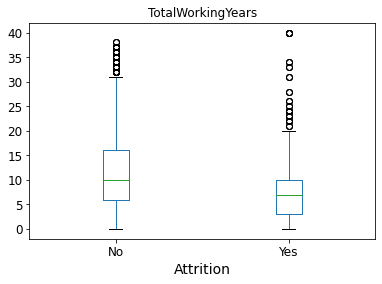

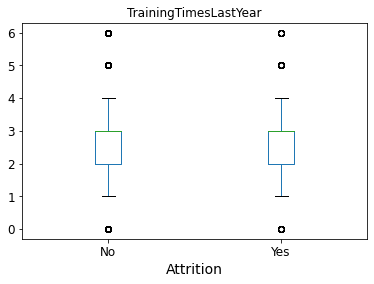

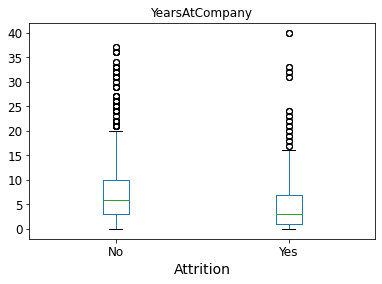

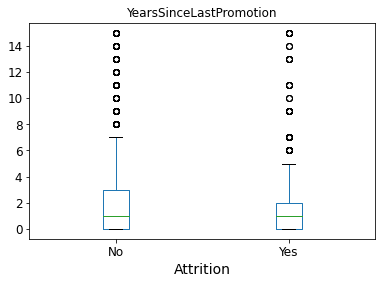

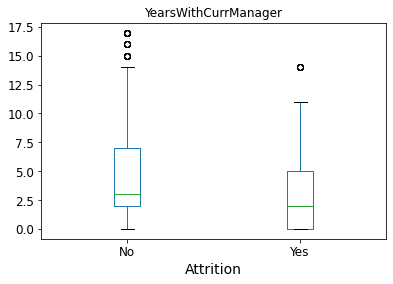

In [26]:
for name_column in allData.select_dtypes(np.number).columns:
    allData.boxplot(by ='Attrition', column = name_column, grid = False, figsize=None) 
    plt.suptitle("")

### B. Test des données

Nous allons utiliser deux tests différents afin de tester la dépendance de la variable attrition avec les autres. On utilise donc Anova lorsque la deuxième variable est quantitative et Khi2 lorsque la deuxième variable est qualitative. Ces tests nous renvoient deux données. La première est la valeur du test et la seconde est la p-value. Cette dernière nous permet d'évaluer la dépendance. Si la p-value est inférieur à 5%, cela veut dire que nous pouvons rejeter l'hypothèse d'indépendance et donc que l'attrition dépend de la variable  choisie.

#### Anova

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for name_column in allData.select_dtypes(include=np.number).columns:
    test_anova = name_column + ' ~ Attrition'
    model = ols(test_anova, data=allData).fit()
    result_anova = sm.stats.anova_lm(model, typ=2)
    print(name_column, "= F : ", result_anova["F"][0], ", p_value : ", result_anova["PR(>F)"][0], "\033[32mDépendant\033[0m" if result_anova["PR(>F)"][0] < 0.05 else "\033[31mIndépendant\033[0m")

Age = F :  114.63168185909088 , p_value :  1.99680161588347e-26 Dépendant
DistanceFromHome = F :  0.4173697538460119 , p_value :  0.5182860428065224 Indépendant
MonthlyIncome = F :  4.288570383801474 , p_value :  0.038427484905952394 Dépendant
NumCompaniesWorked = F :  7.884212755837609 , p_value :  0.0050088441899783275 Dépendant
PercentSalaryHike = F :  4.670236608422217 , p_value :  0.030743386433341374 Dépendant
TotalWorkingYears = F :  131.4519328410399 , p_value :  5.241246810654903e-30 Dépendant
TrainingTimesLastYear = F :  10.796807998328598 , p_value :  0.0010247061915349563 Dépendant
YearsAtCompany = F :  81.07844519572163 , p_value :  3.16388312248436e-19 Dépendant
YearsSinceLastPromotion = F :  4.811020933642641 , p_value :  0.02833033618936241 Dépendant
YearsWithCurrManager = F :  110.23696796790489 , p_value :  1.7339322652883619e-25 Dépendant


#### Khi2

In [28]:
import scipy.stats as stats


for name_column in allData.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        matrice = pd.crosstab(allData['Attrition'], allData[name_column])
        chi2, pvalue,dof, expected = stats.chi2_contingency(matrice)
        print(name_column, "= Statistics : ", chi2, ", p_value : ", pvalue, "\033[32mDépendant\033[0m" if pvalue < 0.05 else "\033[31mIndépendant\033[0m")

EnvironmentSatisfaction = Statistics :  65.20741335391335 , p_value :  4.5288923374665606e-14 Dépendant
JobSatisfaction = Statistics :  51.80338311883507 , p_value :  3.298455638541936e-11 Dépendant
WorkLifeBalance = Statistics :  48.97447919261813 , p_value :  1.3208783070533642e-10 Dépendant
BusinessTravel = Statistics :  72.54724105696552 , p_value :  1.764276972983189e-16 Dépendant
Department = Statistics :  29.090274924488266 , p_value :  4.820888218170406e-07 Dépendant
Education = Statistics :  5.641147679249198 , p_value :  0.2275982630178239 Indépendant
EducationField = Statistics :  46.194921001730584 , p_value :  8.288917469574179e-09 Dépendant
Gender = Statistics :  1.349904410246582 , p_value :  0.24529482862926827 Indépendant
JobLevel = Statistics :  6.2691759264759925 , p_value :  0.1799276801337184 Indépendant
JobRole = Statistics :  25.116313674604072 , p_value :  0.001485544744815264 Dépendant
MaritalStatus = Statistics :  138.49102962254608 , p_value :  8.453859406057

On peut donc constater que l'attrition est liée à de nombreuses variables

### C. Echantillonage stratifié



In [77]:
X = allData.drop(['Attrition'], axis=1)
y = allData['Attrition'].copy()

In [78]:
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
    print(train_index, test_index) # 1 seul tour de boucle si n_splits = 1
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

[2685 3631 1365 ...  743  808 1125] [3662 2179  110 ... 1584 4097    4]


## 3. Pipeline ML

In [79]:
data_set_X_Train = X_train.copy()

data_set_X_Train['PerformanceRating'] = data_set_X_Train['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'}, inplace=True)
data_set_X_Train['EnvironmentSatisfaction'] = data_set_X_Train['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'}, inplace=True)
data_set_X_Train['JobSatisfaction'] = data_set_X_Train['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'}, inplace=True)
data_set_X_Train['JobInvolvement'] = data_set_X_Train['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'}, inplace=True)
data_set_X_Train['WorkLifeBalance'] = data_set_X_Train['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'}, inplace=True)
data_set_X_Train['Education'] = data_set_X_Train['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'}, inplace=True)
data_set_X_Train['JobLevel'] = data_set_X_Train["JobLevel"].replace({ 1 : 'Apprentice', 2: 'Junior Employee',3: 'Employee',4: 'Manager',5 : 'Director'}, inplace=True)
data_set_X_Train['StockOptionLevel'] = data_set_X_Train['StockOptionLevel'].replace({ 0 : 'Low', 1: 'Medium', 2: 'High', 3: 'Very Hight'}, inplace=True)

dataNum = data_set_X_Train.select_dtypes(include=[np.number])
dataCat = data_set_X_Train.select_dtypes(exclude=[np.number])

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = list(dataNum)
cat_attribs = list(dataCat)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

dataSetPipeline = full_pipeline.fit_transform(data_set_X_Train)
dataSetPipeline

array([[-0.42247787,  0.08900296, -0.65113213, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.23465474,  2.04801992, -0.64542702, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.89178735, -1.01294408, -0.82862446, ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 0.01561054,  1.31338856,  0.06390841, ...,  1.        ,
         1.        ,  1.        ],
       [-0.42247787, -0.27831272, -0.5841499 , ...,  1.        ,
         1.        ,  1.        ],
       [-0.09391157, -1.01294408, -0.77410896, ...,  1.        ,
         1.        ,  1.        ]])

In [81]:
dataSetPipeline.shape

(3087, 45)

## 4. Modèle

## 5. Perfomance 